# Classification uncertainty estimation using  Monte Carlo Dropdown 

## Setup

In [11]:
#@title Importing libraries: { display-mode: "form" }
%%capture
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
!pip install nbdev
from fastbook import *
from fastai.vision.widgets import *
import nbdev
from fastai.vision import *
from pathlib import Path
import PIL

## Load data

Laoad CIFAR10 dataset using FastAI library utility function

In [12]:
path = untar_data(URLs.CIFAR)

Image files are downloaded from the internet and stored in the local folder

In [49]:
path

Path('/root/.fastai/data/cifar10')

### Build dataloader using FastAI API

In [13]:
data = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                    get_items=get_image_files,
                    get_y=parent_label,
                    item_tfms=Resize(40))

In [14]:
dls = data.dataloaders(path, bs=64, valid_pct=0.2, seed=42,)

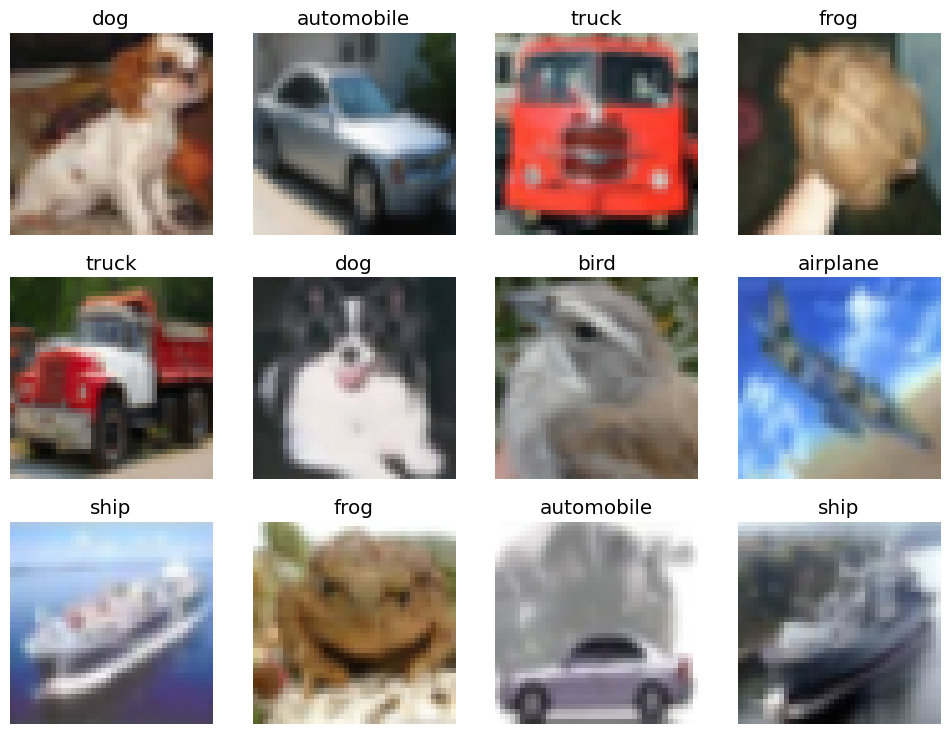

In [15]:
dls.valid.show_batch(max_n=12, nrows=3)

## Build learner using FastAI API

Download pretrained resnet18 model from the internet and fine tune it using CIFAR10 dataset

In [16]:
learner = vision_learner(dls, resnet18, metrics=accuracy)
learner.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 35.0MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.453050,1.227515,0.569917,02:00


epoch,train_loss,valid_loss,accuracy,time
0,0.843766,0.735102,0.744333,02:29
1,0.625382,0.584682,0.800583,02:02
2,0.503799,0.550225,0.815417,02:10
3,0.329378,0.547031,0.824917,02:31
4,0.201068,0.611556,0.826417,01:55
5,0.107022,0.690746,0.831583,02:07
6,0.050685,0.736478,0.835417,02:18
7,0.026100,0.778103,0.841583,02:19
8,0.016225,0.795018,0.843583,01:57
9,0.009695,0.796357,0.844333,01:54


## Model validation

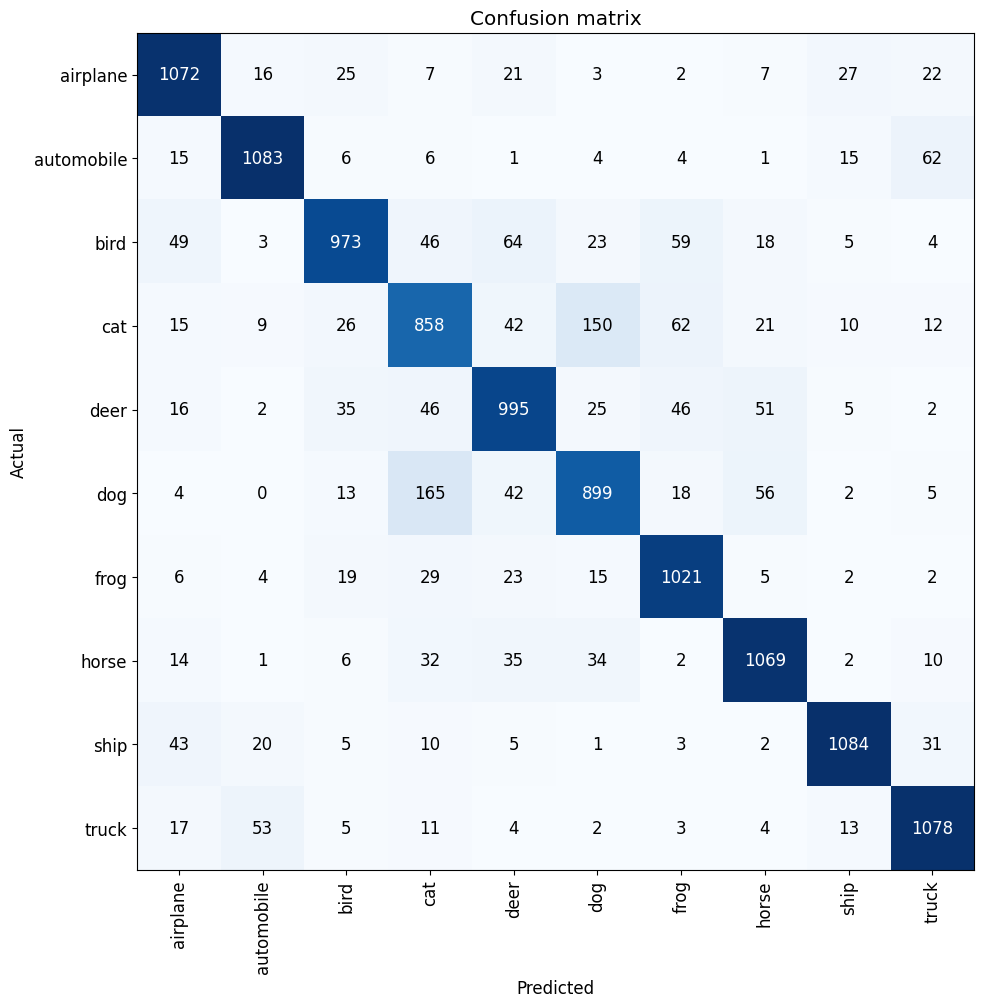

In [17]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(13,10))

### Export trained model

In [18]:
learner.export('cifar10.pkl')

### Save a copy of the model in permanent storage [ONLY IF NOTEBOOK IS RUN IN COLAB]

In [19]:
def copy_model_to_google_drive(filename,src_path,dest_path):
  '''copy file from Colab VM  to google drive'''
  dest_filename=dest_path+"/"+filename
  #copy to external storage (outside Colab VM)
  model_source=src_path+"/"+filename
  #!cp $model_source  $dest_filename
  #copy to external storage (outside Colab VM)
  get_ipython().system('cp $model_source  $dest_filename')

In [20]:
copy_model_to_google_drive('cifa10.pkl','/content','/content/gdrive/MyDrive')

## Get prediction from the model on validation dataset

In [42]:
predictions, targets, decoded = learner.get_preds(with_decoded=True)

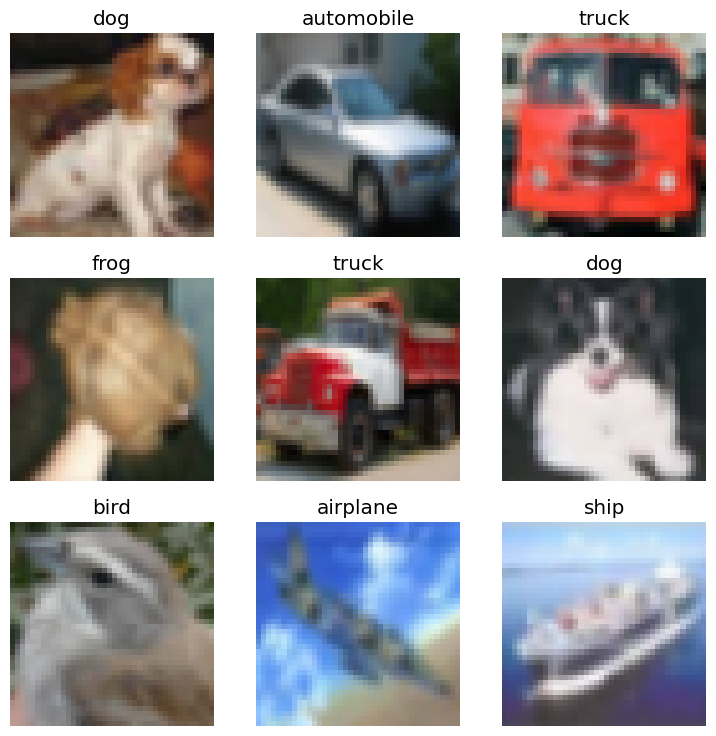

In [51]:
learner.dls.valid.show_batch()

### Look for incorrect predictions

In [46]:
incorrect_predictions = targets!=decoded
print("incorrect prediciton:")
print(incorrect_predictions)

incorrect prediciton:
tensor([False, False, False,  ..., False, False, False])


In [47]:
indices = [i for i, x in enumerate(incorrect_predictions) if x==true]

In [48]:
indices

[]

In [43]:
print("target: ")
print(targets)
print("predictions (decoded):")
print(decoded)
print("classification errors (class distance):")
print(targets-decoded)

target: 
tensor([5, 1, 9,  ..., 9, 9, 9])
predictions (decoded):
tensor([5, 1, 9,  ..., 9, 9, 9])
classification errors (class distance):
tensor([0, 0, 0,  ..., 0, 0, 0])


## Classification uncertainty estimation using Monte Carlo Dropout

### MCD implmentation from ML4M

In [37]:
def MC_dropout_prediction(learn,data_loader,n_samples,activation=None):
# Call get_preds n times, then stack the predictions, yielding a tensor with shape [# of samples, batch_size, ...]
    dist_preds = []
    for i in range(n_samples):
        preds, targs, decoded = learn.get_preds(with_decoded=True, act=activation, cbs=[MCDropoutCallback()])
        dist_preds += [preds]

    y_pred_dist=torch.stack(dist_preds)
    return y_pred_dist

In [38]:
def no_softMax(x): return x

## Generate value distribution for each prediction

In [40]:
y_pred_dist_MC_logit=MC_dropout_prediction(learner,null,10,activation=no_softMax)

### analyze the distribution of values for one random sample

In [52]:
test_img_index = 4

TensorCategory(9)


<Axes: >

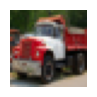

In [57]:
img= learner.dls.valid.dataset[test_img_index]
print(img[1])
img[0].show()

In [58]:
predicted_class = decoded[test_img_index].numpy()
true_class = targets[test_img_index].numpy()

In [61]:
print("decoded: " +str(decoded[test_img_index].numpy()))
print("target: " +str(targets[test_img_index].numpy()))

decoded: 9
target: 9


In [81]:
learner.dls.vocab

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

<ipython-input-85-20c18ff104d9>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_soc, cut=0, shade=True)
<ipython-input-85-20c18ff104d9>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_soc, cut=0, shade=True)
<ipython-input-85-20c18ff104d9>:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_soc, cut=0, shade=True)


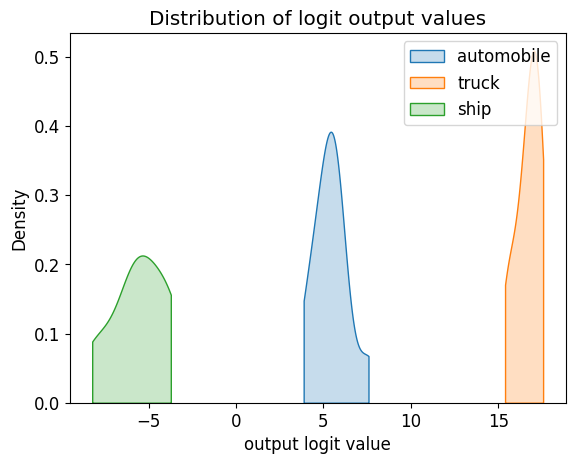

In [85]:
import seaborn as sns
soc_classes=learner.dls.vocab
y_pred_soc=y_pred_dist_MC_logit[:,test_img_index,1]
y_pred_point_soc=y_pred_dist_MC_logit[:,test_img_index,1].mean(axis=0)
std_dev=y_pred_dist_MC_logit[:,test_img_index,1].std(axis=0)
sns.kdeplot(y_pred_soc, cut=0, shade=True)
#plt.axvline(y_pred_point_soc, color='red')

y_pred_soc=y_pred_dist_MC_logit[:,test_img_index,true_class]
y_pred_point_soc=y_pred_dist_MC_logit[:,test_img_index,true_class].mean(axis=0)
std_dev=y_pred_dist_MC_logit[:,test_img_index,true_class].std(axis=0)
sns.kdeplot(y_pred_soc, cut=0, shade=True)
#plt.axvline(y_pred_point_soc, color='red')

y_pred_soc=y_pred_dist_MC_logit[:,test_img_index,8]
y_pred_point_soc=y_pred_dist_MC_logit[:,test_img_index,8].mean(axis=0)
std_dev=y_pred_dist_MC_logit[:,test_img_index,8].std(axis=0)
sns.kdeplot(y_pred_soc, cut=0, shade=True)
#plt.axvline(y_pred_point_soc, color='red')

plt.xlabel("output logit value")
plt.legend([soc_classes[1],soc_classes[true_class],soc_classes[8]])

plt.title("Distribution of logit output values")
plt.show()

<ipython-input-65-d390eef74669>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_soc, cut=0, shade=True)
<ipython-input-65-d390eef74669>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_soc, cut=0, shade=True)


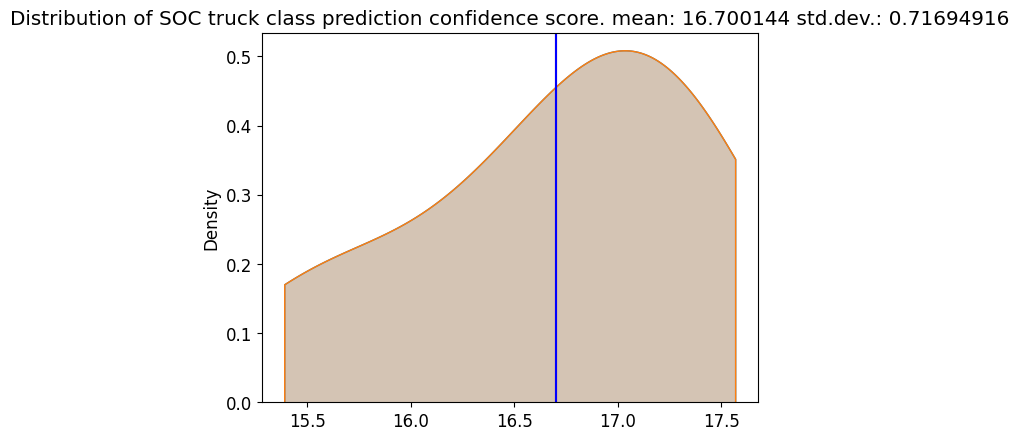

In [65]:
import seaborn as sns
soc_classes=learner.dls.vocab
y_pred_soc=y_pred_dist_MC_logit[:,test_img_index,predicted_class]
y_pred_point_soc=y_pred_dist_MC_logit[:,test_img_index,predicted_class].mean(axis=0)
std_dev=y_pred_dist_MC_logit[:,test_img_index,predicted_class].std(axis=0)
sns.kdeplot(y_pred_soc, cut=0, shade=True)
plt.axvline(y_pred_point_soc, color='red')

y_pred_soc=y_pred_dist_MC_logit[:,test_img_index,true_class]
y_pred_point_soc=y_pred_dist_MC_logit[:,test_img_index,true_class].mean(axis=0)
std_dev=y_pred_dist_MC_logit[:,test_img_index,true_class].std(axis=0)
sns.kdeplot(y_pred_soc, cut=0, shade=True)
plt.axvline(y_pred_point_soc, color='blue')

plt.title("Distribution of logit output values for "+ soc_classes[predicted_class]+". mean: "+str(y_pred_point_soc.numpy())+" std.dev.: "+str(std_dev.numpy()))
plt.show()

In [68]:
y_pred_dist_MC=MC_dropout_prediction(learner,null,10)

<ipython-input-73-6244f109b57d>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_soc, cut=0, shade=True)
<ipython-input-73-6244f109b57d>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_soc, cut=0, shade=True)


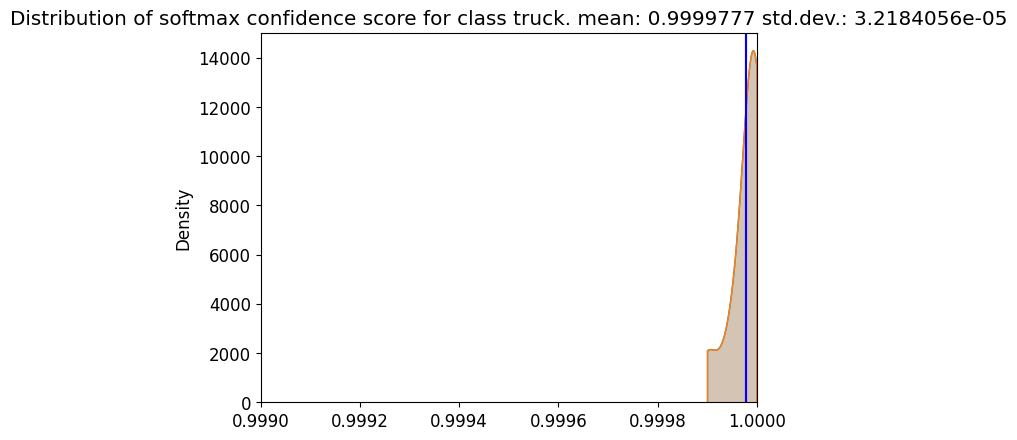

In [73]:
y_pred_soc=y_pred_dist_MC[:,test_img_index,predicted_class]
y_pred_point_soc=y_pred_dist_MC[:,test_img_index,predicted_class].mean(axis=0)
std_dev=y_pred_dist_MC[:,test_img_index,predicted_class].std(axis=0)
sns.kdeplot(y_pred_soc, cut=0, shade=True)
plt.axvline(y_pred_point_soc, color='red')

y_pred_soc=y_pred_dist_MC[:,test_img_index,true_class]
y_pred_point_soc=y_pred_dist_MC[:,test_img_index,true_class].mean(axis=0)
std_dev=y_pred_dist_MC[:,test_img_index,true_class].std(axis=0)
sns.kdeplot(y_pred_soc, cut=0, shade=True)
plt.axvline(y_pred_point_soc, color='blue')
plt.xlim(0.999,1)

plt.title("Distribution of softmax confidence score for class "+ soc_classes[predicted_class]+". mean: "+str(y_pred_point_soc.numpy())+" std.dev.: "+str(std_dev.numpy()))
plt.show()

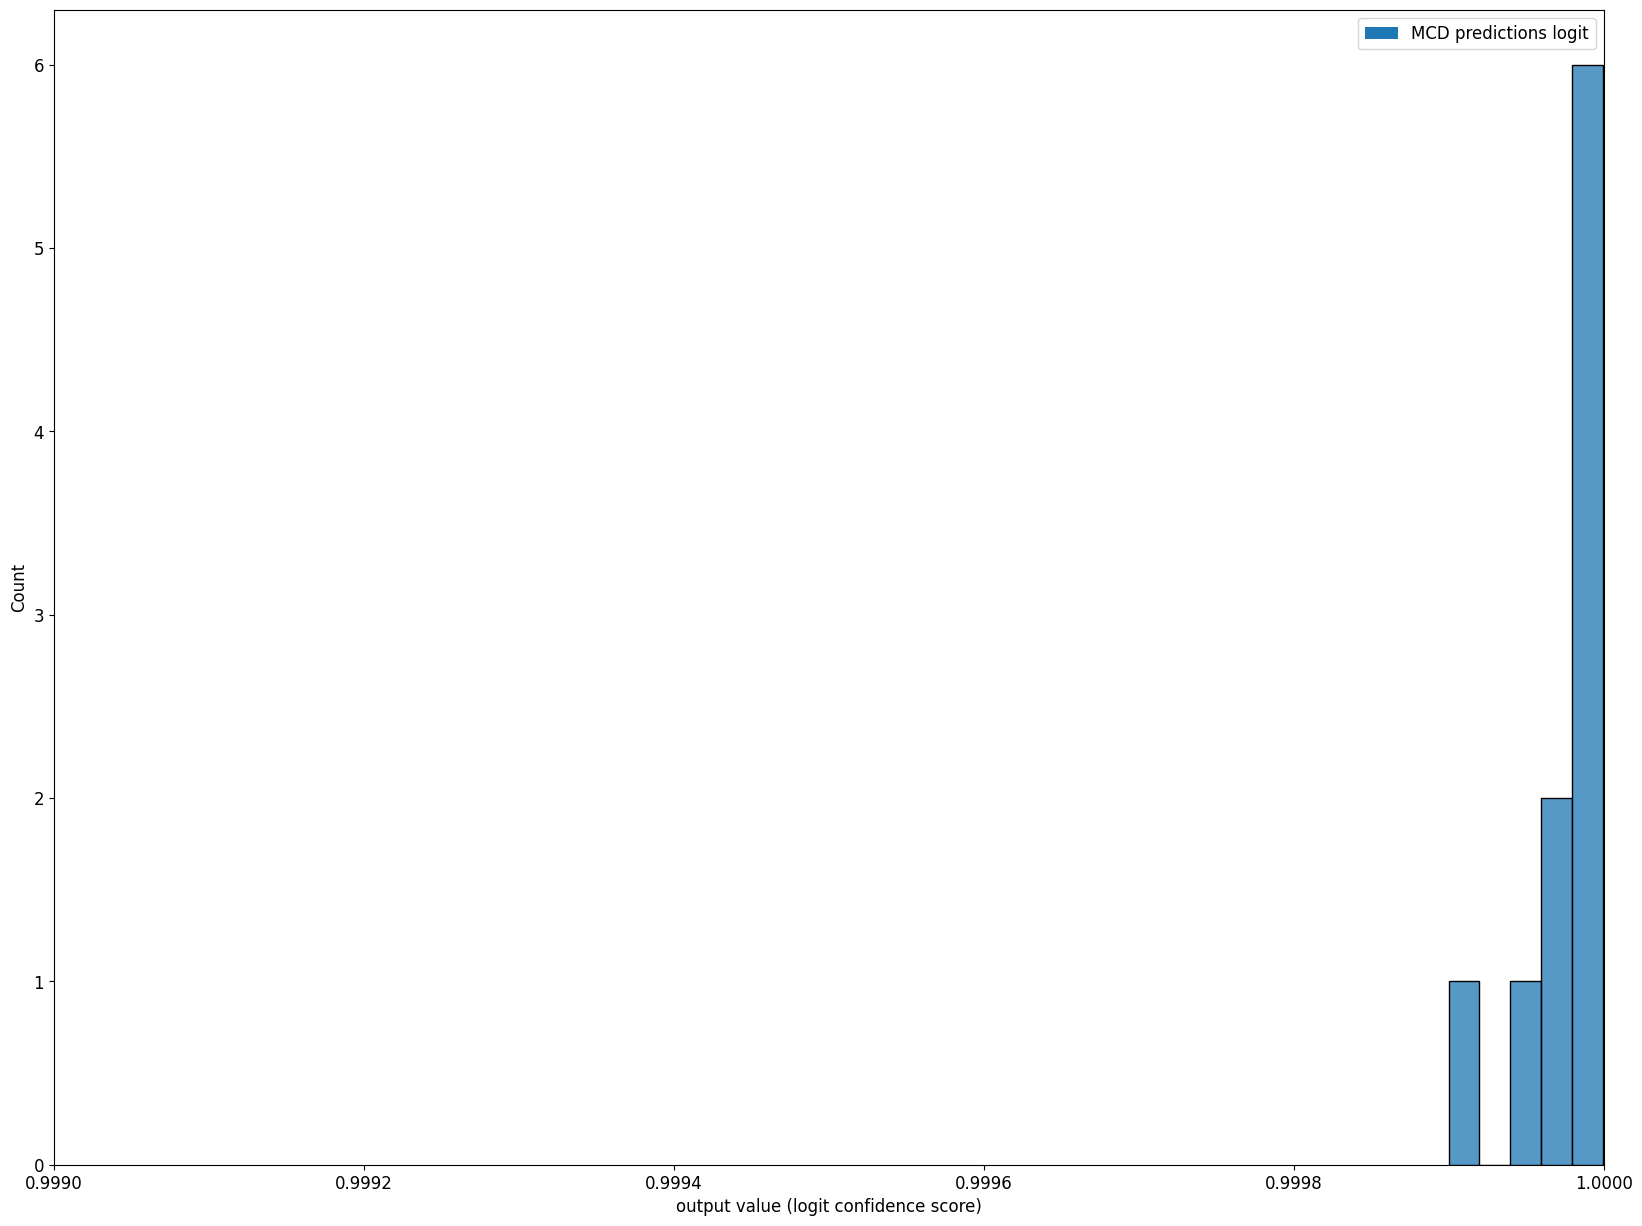

In [80]:
plt.figure(figsize=(20,15))
sns.histplot(y_pred_dist_MC[:,test_img_index,predicted_class])
plt.xlim([0.999,1])
#plt.ylim([0,200])
plt.xlabel("output value (logit confidence score)")
plt.legend(["MCD predictions logit"])